### Exercises

#### CRUD operations:


**1**: You will continue to work on the MCU network for a while. Who are the 10 fastest in the MCU ? Are they related to each other ?

**2**: How many have collaborated atleast more than 10 times with another superhero?

**3**: Did the weakest of the MCU collaborated with the strongest ?

**4**: Give a stats that interests you !

**5**: Create a new db called "master". Create a graph from the M1 class with name and random age between 20 and 30, Group of 3 that collab (undirected relation).

**6**: Get the age for people YOU collaborate with.

**7**: Get nodes with age > 25.

### Real world problem:

**8**: Using the downloaded data in TODO 11 of chapter II, create a collaboration network between authors for papers after 2021 (same author if same name). Insert it in neo4j in a db called "arxiv".

**9**: Get the density of degrees of the collaboration network

**10**: Do a for loop for i in range(500) for each i remove nodes with a degree less than i.


In [3]:
import seaborn as sns
import py2neo
import pandas as pd
import itertools
import tqdm

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="mcu")


In [4]:
#**1**: You will continue to work on the MCU network for a while. Who are the 10 fastest in the MCU ? Are they related to each other ?
query = """MATCH (a)
WHERE exists(a.Speed)
RETURN a
ORDER BY a.Speed DESC
LIMIT 10"""

data = graph.run(query).to_data_frame()
list(data['a'])

[Node('Superhero', Combat=56, Durability=84, Intelligence=75, Power=100, Speed=100, Strength=67, Total=482, id_=1009184, name='Black Bolt'),
 Node('Superhero', Combat=85, Durability=110, Intelligence=88, Power=100, Speed=100, Strength=85, Total=568, id_=1010764, name='Stardust'),
 Node('Superhero', Combat=56, Durability=60, Intelligence=63, Power=57, Speed=100, Strength=28, Total=364, id_=1009524, name='Quicksilver'),
 Node('Superhero', Combat=25, Durability=100, Intelligence=38, Power=100, Speed=100, Strength=60, Total=423, id_=1009477, name='Nova'),
 Node('Superhero', Combat=85, Durability=100, Intelligence=69, Power=100, Speed=92, Strength=100, Total=546, id_=1009664, name='Thor'),
 Node('Superhero', Combat=32, Durability=101, Intelligence=63, Power=100, Speed=84, Strength=100, Total=480, id_=1009592, name='Silver Surfer'),
 Node('Superhero', Combat=70, Durability=100, Intelligence=100, Power=100, Speed=83, Strength=100, Total=553, id_=1009312, name='Galactus'),
 Node('Superhero', C

<img src="img/graph.png"> 

On peut voir que les 10 plus rapides sont plutot liés les uns aux autres.

In [5]:
# (Repris du cours) 
characters2comics = pd.read_csv("data/Chap4/Marvel_Superheroes/charactersToComics.csv")
characters2comics = characters2comics.drop_duplicates()
transaction_list = []

# MERGE = if pattern does not exists ON CREATE
# If pattern exists do ON MATCH



transaction = """UNWIND $json as data
MATCH (a:Superhero),(b:Superhero)
WHERE a.id_ = data.id_1 AND b.id_ = data.id_2
MERGE (a)-[r:RELATION]->(b)
ON CREATE
    SET r.n_collab = 1
ON MATCH
    SET r.n_collab = r.n_collab + 1
"""

it = 0   
for comic in tqdm.tqdm(characters2comics.groupby(["comicID"])):
    related_ids = comic[1]["characterID"]
    for combi in list(itertools.combinations(related_ids, 2)):
        sh1 = combi[0]
        sh2 = combi[1]
        transaction_list.append({"id_1":sh1,"id_2":sh2})
        it +=1
        if it % 1000 == 0:
            graph.run(transaction, json=transaction_list)
            transaction_list = []

graph.run(transaction, json=transaction_list)
pass

100%|██████████| 22250/22250 [00:28<00:00, 767.83it/s] 


In [6]:
#**2**: How many have collaborated atleast more than 10 times with another superhero?

query = """MATCH (s1:Superhero)-[r:RELATION]->(s2:Superhero)
WHERE r.n_collab > 10
RETURN count(*) AS Collaborations_nbr"""

data = graph.run(query).to_data_frame()
data


,Collaborations_nbr
0,13159


In [19]:
# **3**: Did the weakest of the MCU collaborated with the strongest ?
query = """

MATCH (w:Superhero), (s:Superhero)
WITH min(w.Strength) AS minStrength, max(s.Strength) AS maxStrength
MATCH (weakest:Superhero {Strength: minStrength}), (strongest:Superhero {Strength: maxStrength})
MATCH (strongest)-[r:RELATION]->(weakest)
RETURN weakest.name AS WeakestSuperhero, strongest.name AS StrongestSuperhero, r as Relationship
"""

data = graph.run(query).to_data_frame()
print('\nVoici les relations entre les Superhero avec le moins de forces et les supers avec le plus de force (les 10 premiers):\n\n ', data[0:10])



Voici les relations entre les Superhero avec le moins de forces et les supers avec le plus de force:

     WeakestSuperhero StrongestSuperhero      Relationship
0             Namor           Galactus  {'n_collab': 39}
1              Lyja           Galactus   {'n_collab': 9}
2          Psylocke           Galactus   {'n_collab': 6}
3          Guardian           Galactus   {'n_collab': 9}
4   Mister Sinister           Galactus   {'n_collab': 3}
5             Morph           Galactus   {'n_collab': 9}
6         Meteorite               Hulk   {'n_collab': 3}
7  Lady Deathstrike               Hulk   {'n_collab': 6}
8              Lyja               Hulk   {'n_collab': 6}
9             Namor               Hulk  {'n_collab': 39}


In [21]:
# **4**: Give a stats that interests you !
query = """
MATCH (s:Superhero)
RETURN AVG(s.Intelligence) AS avg_intelligence
"""

data = graph.run(query).to_data_frame()
print("\nLa moyenne d'intelligence: \n\n", data)


La moyenne d'intelligence: 

    avg_intelligence
0         54.664975


In [26]:
# **5**: Create a new db called "master". Create a graph from the M1 class with name and random age between 20 and 30, Group of 3 that collab (undirected relation).

import random

# Connect to the Neo4j database
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="master")
graph.delete_all()


students = []
for i in range(1, 10):  
    student = py2neo.Node("Student", name=f"Student {i}", age=random.randint(20, 30))
    students.append(student)
    graph.create(student)

for i in range(0, len(students), 3):
    if i+2 < len(students):  
        a, b, c = students[i:i+3]
        graph.create(py2neo.Relationship(a, "RELATION", b))
        graph.create(py2neo.Relationship(b, "RELATION", c))
        graph.create(py2neo.Relationship(c, "RELATION", a))



<img src="img/graph2.png"> 

In [37]:
# **6**: Get the age for people YOU collaborate with.
query = """
MATCH (s:Student {name: 'Student 1'})-[:RELATION]-(collaborators)
RETURN collaborators.name AS Name, collaborators.age AS Age
"""

data = graph.run(query).to_data_frame()
print('\nSupposons que je suis "Student 1": \n\n',data)



Supposons que je suis "Student 1": 

         Name  Age
0  Student 3   22
1  Student 2   24


In [41]:
# **7**: Get nodes with age > 25.
query = """
MATCH (n)
WHERE n.age > 25
RETURN n.name AS Name, n.age AS Age
"""

data = graph.run(query).to_data_frame()
print('\nLes étudiants qui ont plus de 25 ans: \n\n', data)


Les étudiants qui ont plus de 25 ans: 

         Name  Age
0  Student 4   28
1  Student 7   30


In [ ]:
# **8**: Using the downloaded data in TODO 11 of chapter II, create a collaboration network between authors for papers after 2021 (same author if same name). Insert it in neo4j in a db called "arxiv".

# **9**: Get the density of degrees of the collaboration network

# **10**: Do a for loop for i in range(500) for each i remove nodes with a degree less than i.

### Real World application 3


1) Each paper has a list of author and affiliations. The first step is to create a node per author with a list of affiliation as attribute. If a name appears multiple times consider it as a single person. Create an edge between two authors if they are on the same paper. You can use any kind of operation to clean the data before inserting, you decide which preprocessing step is the most convenient.

2) How many authors have more than 2 affiliations ?

3) Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

4) Which country has seen the most international collaboration ?

5) Who are the top 10 collaborators and what is their affiliation ?

6) Sandbox exercise: think of a problematic and try to answer it.

### /!\\/!\ Lien indisponible /!\\/!\:

https://we.tl/t-6afLCDGRsg

### Real World application 4

change the database "neo4j" to the database "movie". Go to the browser and run on the browser console :play movie-graph then copy the queries on the console and run it. Congrats you just imported a brand new sample of data. Answer the following questions with cypher queries.

1) How many actors played in more than 2 movie ? Get their names and year they were born.

2) In how many movies did Tom hanks play ?

3) In average in how many movies do actors play in ?

4) In average how many actors are there in a movie ?

5) In average how many writers is needed to write a movie ?

6) What is the proportion of writers that also directed the movie ?

7) Do an histogram of the year of release for the movies.

8) Who are the 10 actors with the most movie played in

9) Delete every movie made by a director of your choosing

10) Give some statistics that you find interesting.

11) Sandbox exercise: think of a problematic and try to answer it.

In [49]:
# 1) How many actors played in more than 2 movie ? Get their names and year they were born.
import random

graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "password_tuts"), name="movie")

query = """
MATCH (a:Person)-[:ACTED_IN]->(m:Movie)
WITH a, COUNT(m) AS movies
WHERE movies > 2
RETURN a.name AS name, a.born AS yearBorn
"""
data = graph.run(query).to_data_frame()
print(data)




                  name  yearBorn
0         Hugo Weaving      1960
1   Laurence Fishburne      1961
2     Carrie-Anne Moss      1967
3         Keanu Reeves      1964
4     Cuba Gooding Jr.      1968
5          Kevin Bacon      1958
6       Jack Nicholson      1937
7           Tom Cruise      1962
8             Meg Ryan      1961
9           Helen Hunt      1963
10      Robin Williams      1951
11           Tom Hanks      1956
12        Gene Hackman      1930
13           Ben Miles      1967
14         Bill Paxton      1955


In [51]:
# 2) In how many movies did Tom hanks play ?
query = """
MATCH (p:Person {name: 'Tom Hanks'})-[:ACTED_IN]->(m:Movie)
RETURN COUNT(m) AS count
"""
data = graph.run(query).to_data_frame()
print(data)


   count
0     12


In [54]:
# 3) In average in how many movies do actors play in ?
query = """
MATCH (a:Person)-[:ACTED_IN]->(m:Movie)
WITH a, COUNT(m) AS movies
RETURN AVG(movies) AS average
"""
data = graph.run(query).evaluate()
print(f"\nEn moyenne, les acteurs jouent dans environ {data:.2f} films: \n\n", data)



En moyenne, les acteurs jouent dans environ 1.69 films: 

 1.6862745098039222


In [56]:
# 4) In average how many actors are there in a movie ?
query = """
MATCH (m:Movie)<-[:ACTED_IN]-(a:Person)
WITH m, COUNT(a) AS actors
RETURN AVG(actors) AS average
"""
data = graph.run(query).evaluate()
print(f"\nEn moyenne, il y a {data:.2f} acteurs par film: \n\n", data)


En moyenne, il y a 4.53 acteurs par film: 

 4.526315789473684


In [58]:
# 5) In average how many writers is needed to write a movie ?
query = """
MATCH (m:Movie)<-[:WROTE]-(w:Person)
WITH m, COUNT(w) AS writers
RETURN AVG(writers) AS average
"""
data = graph.run(query).evaluate()
print(f"\nEn moyenne, {data:.2f} écrivains sont nécessaires pour écrire un film: \n\n", data)



En moyenne, 1.25 écrivains sont nécessaires pour écrire un film: 

 1.25


In [61]:
# 6) What is the proportion of writers that also directed the movie ?
query = """
MATCH (p:Person)-[:WROTE]->(m:Movie)
WITH p, COUNT(m) AS WrittenMovies
MATCH (p)-[:DIRECTED]->(m)
WITH p, WrittenMovies, COUNT(m) AS DirectedMovies
RETURN SUM(DirectedMovies * 1.0 / WrittenMovies) AS proportion
"""
data = graph.run(query).evaluate()
print("\nProportion d'écrivains qui sont aussi directeurs: \n\n", data)



Proportion d'écrivains qui sont aussi directeurs: 

 9.0


C:\Users\ndubo\AppData\Local\Temp\ipykernel_16560\3552216461.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)


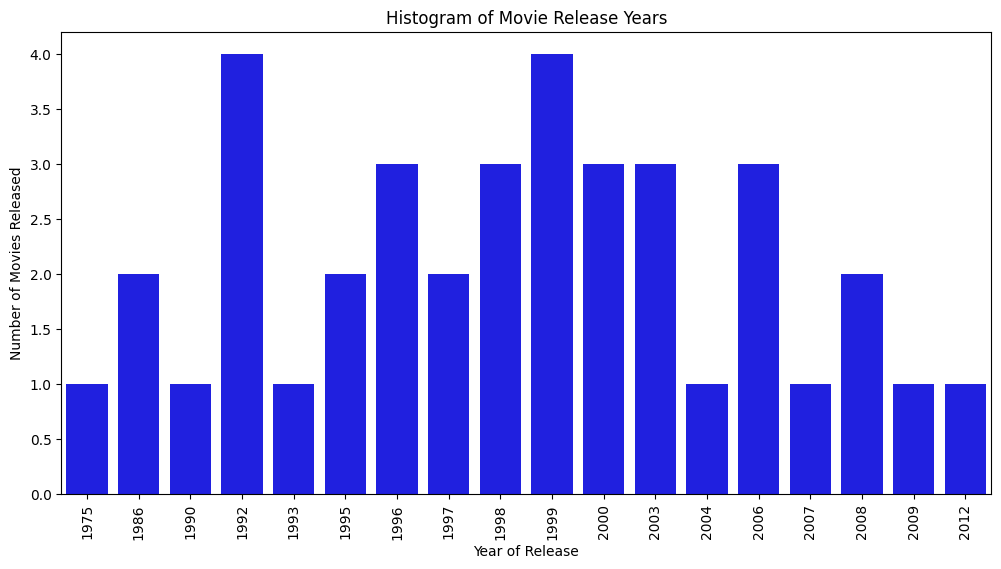

In [69]:
import seaborn as sns 
import matplotlib.pyplot as plt

# 7) Do an histogram of the year of release for the movies.
query = """
MATCH (m:Movie)
RETURN m.released AS year, COUNT(*) AS count
ORDER BY year
"""
data = graph.run(query).to_data_frame()

# Create a bar plot for the histogram data
plt.figure(figsize=(12, 6))  
bar_plot = sns.barplot(data=data, x='year', y='count', color='blue')
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)  

# Set plot title and labels
plt.title('Histogram of Movie Release Years')
plt.xlabel('Year of Release')
plt.ylabel('Number of Movies Released')

# Show the plot
plt.show()



In [71]:
# 8) Who are the 10 actors with the most movie played in
query = """
MATCH (a:Person)-[:ACTED_IN]->(m:Movie)
WITH a, COUNT(m) AS movies
ORDER BY movies DESC
LIMIT 10
RETURN a.name AS actor, movies
"""
data = graph.run(query).to_data_frame()
print('\nLes acteurs qui ont joué dans le plus de films: \n\n', data)




Les acteurs qui ont joué dans le plus de films: 

                 actor  movies
0           Tom Hanks      12
1        Keanu Reeves       7
2            Meg Ryan       5
3      Jack Nicholson       5
4        Hugo Weaving       5
5    Cuba Gooding Jr.       4
6         Kevin Bacon       3
7  Laurence Fishburne       3
8    Carrie-Anne Moss       3
9          Tom Cruise       3


In [72]:
# 9) Delete every movie made by a director of your choosing
query = """
MATCH (m:Movie)<-[:DIRECTED]-(d:Person {name: 'Lana Wachowski'})
DETACH DELETE m
"""
graph.run(query)
print("Les films dirigés par Lana Wachowski ont été supprimés.")



Les films dirigés par Lana Wachowski ont été supprimés.


In [ ]:
# 10) Give some statistics that you find interesting.



In [ ]:
# 11) Sandbox exercise: think of a problematic and try to answer it.

## Homework 5

You will work on a Twitch dataset found [here](https://www.kaggle.com/andreagarritano/twitch-social-networks). The goal is to learn more about the feat&fun on Twitch. First thing to do is create the network on Neo4j. Insert the node
from Twitch/FR_target and then the edges from Twitch/FR_edges.csv in neo4j. Answer the following using cypher queries

1) Give the IDs of the top 10 streamers that have atleast one collaboration.

2) Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

3) How many streamers has the tag "mature" ?

4) Is the collaboration correlated to the "mature" tag ?

5) Do partners collaborate more than non partners ?

6) Sandbox exercise: think of a problematic and try to answer it.